In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load

## Load data

In [36]:
tree = load('MODELLING DATA/tree_model.joblib')

import pickle
with open('MODELLING DATA/train_test_data.pickle','rb') as file:
    X_train_trans, X_test_trans, y_train, y_test = pickle.load(file)
with open('MODELLING DATA/preproc_data.pickle','rb') as file:
    X_train,X_test,categorical,numeric,preprocessor = pickle.load(file)

## Compare using a scaler

Try using a standard scaler for the numeric features in order to analyze it's impact on performance.

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Create a list of categorical column names and numeric column names
categorical_columns = list(categorical)
numeric_columns = list(numeric)

# Create transformers for categorical and numeric columns
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

# Create a column transformer that applies transformers to the respective column types
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
        ('num', numeric_transformer, numeric_columns)
    ])

# Fit and transform the data
X_train_trans_np = preprocessor.fit_transform(X_train)
X_train_trans_new = pd.DataFrame(X_train_trans_np, columns=preprocessor.get_feature_names_out())
X_test_trans_new = preprocessor.transform(X_test)

In [38]:
from sklearn.tree import DecisionTreeRegressor

tree_scale = DecisionTreeRegressor()
tree_scale.fit(X_train_trans_new,y_train)

print('Previous decision tree: ', tree.score(X_test_trans,y_test))
print('Tree using scaler: ', tree_scale.score(X_test_trans_new,y_test))

Previous decision tree:  0.9838482330716256
Tree using scaler:  0.9809189478701955


c:\Users\danip\Documents\Python venvs\ml_venv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


No improvement when using a scaler.

## Cross validation

In [39]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(5)
tree_score = cross_val_score(tree, X_train_trans, y_train, cv=kf)
print('Inicial decision tree')
print(tree_score)
print('Mean score across folds: ', np.mean(tree_score))

new_tree_score = cross_val_score(tree_scale, X_train_trans, y_train, cv=kf)
print('\nDecision tree with scaler')
print(new_tree_score)
print('Mean score across folds: ', np.mean(new_tree_score))

Inicial decision tree
[0.98605677 0.98431535 0.98568506 0.98589847 0.98532464]
Mean score across folds:  0.985456058214047

Decision tree with scaler
[0.98533237 0.9884691  0.98453615 0.98821114 0.98365117]
Mean score across folds:  0.9860399866247761


The scaler makes no difference, at least regarding the r2 metric.

## Parameter tuning

In [40]:
# See what is the depth of the tree trained with default parameters
tree.get_depth()

23

Depths to test:  [ 5  8 11 14 17 20 23 26 29]


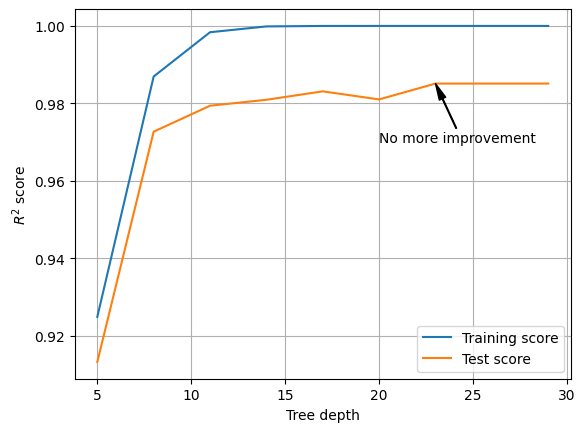

In [41]:
depths = np.arange(5,30,3)
print('Depths to test: ', depths)
r2_train = []
r2_test = []

for depth in depths:
    tree_tuning = DecisionTreeRegressor(max_depth=depth, random_state=123)
    tree_tuning.fit(X_train_trans,y_train)

    r2_train.append(tree_tuning.score(X_train_trans,y_train))
    r2_test.append(tree_tuning.score(X_test_trans,y_test))

plt.figure()
plt.plot(depths,r2_train,label='Training score')
plt.plot(depths,r2_test,label='Test score')
plt.xlabel('Tree depth')
plt.ylabel('$R^2$ score')
plt.legend()
plt.grid()
plt.annotate('No more improvement', xy = (depths[6], r2_test[6]), xytext=(20,0.97),
             arrowprops={'facecolor':'black', 'width':0.5, 'headwidth':5})
plt.show()

## Grid Search

In [42]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':[5,8,10,12,15,18,20,22], 'splitter':['best','random']}
grid = GridSearchCV(estimator=tree, param_grid=params, cv=kf)
grid.fit(X_train_trans, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 8, 10, 12, 15, 18, 20, 22],
                         'splitter': ['best', 'random']})

In [43]:
print('Best score: ',grid.best_score_)
print('Best params: ', grid.best_params_)

Best score:  0.985589730738057
Best params:  {'max_depth': 22, 'splitter': 'best'}


Finnaly settle for an r2 score of 98.57% using a Decision Tree Regressor with a depth of 22.